# Assignment 4: Image Super-Resolution

In [2]:
import cv2
import gc
import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torchvision
from torchvision import models
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import warnings
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, DataLoader

warnings.filterwarnings('ignore')
%matplotlib inline
img_to_tensor = ToTensor()
tensor_to_pil_img = ToPILImage(mode='RGB')
tensor_to_img = lambda img: cv2.cvtColor(np.array(tensor_to_pil_img(img)), cv2.COLOR_RGB2BGR)

In [ ]:
# For work with google colab.
from google.colab import drive
import nltk
nltk.download('punkt')
drive.mount('/content/drive/')
os.chdir('drive/My Drive/Y-Data/Deep Learning/assignment4/')

In [16]:
!mkdir data
!wget  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar -P data/
!tar -xf data/VOCtrainval_06-Nov-2007.tar -C data/

--2020-04-29 09:54:26--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘data/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  73.1MB/s    in 6.1s    

2020-04-29 09:54:32 (71.9 MB/s) - ‘data/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



## Stage 1

### Create dataset

We would like to create a dataset and a data-loader for the training of super-resolution network.
We will use self-supervision to create our dataset.

* Create a dataset with images of 3 different sizes:
X - 72x72x3 y_mid – 144x144x3 y_large – 288x288x3
You may choose to either persist these different sizes to disk or create them on-the-fly within your data loader


* Split them into training and validating our model, for simplicity, we will use the first 1000 images (~20%) for validation and the rest for training. (note you should have 5011 images in total but are welcome to add more if you wish to)

Note – I strongly recommend to only work on a sample of the data to make the process of loading and processing faster. This is a good practice for quick development of the loading pipeline and initial model creation. Once everything is working the way we expect it to work, we can increase the number of images we load and be sure that the process runs smoothly.

* Next, present few images so that we can compare the training with our desired labels, this process is good for verifying that

In [21]:
# Directory with raw images downloaded.
# IMG_DIR = 'small-set/'
IMG_DIR = 'data/VOCdevkit/VOC2007/JPEGImages/'
# Directory with images of 3 different sizes: small, medium, large
DATASET_DIR = 'dataset/'

!mkdir $DATASET_DIR

SMALL_IMG_SIZE = 72
MEDIUM_IMG_SIZE = 144
LARGE_IMG_SIZE = 288

image_sizes = [SMALL_IMG_SIZE, MEDIUM_IMG_SIZE, LARGE_IMG_SIZE]

test_size = 0.2

path_to_name = lambda f: os.path.splitext(os.path.basename(f))[0]
full_img_list = [path_to_name(img_path) for img_path in glob.glob(IMG_DIR + '*.jpg')]
img_list = full_img_list
len(img_list)

5011

In [22]:
def write_dataset_image(img, img_name, img_size):
  out_img = cv2.resize(img, (img_size, img_size))
  out_path = DATASET_DIR + img_name + '_' + str(img_size) + '.jpg'
#   print(out_path)
  cv2.imwrite(out_path, out_img)

def process_image(img_name):
  img = cv2.imread(IMG_DIR + img_name + '.jpg')
  for img_size in image_sizes:
    write_dataset_image(img, img_name, img_size)

for i in img_list:
    process_image(i)

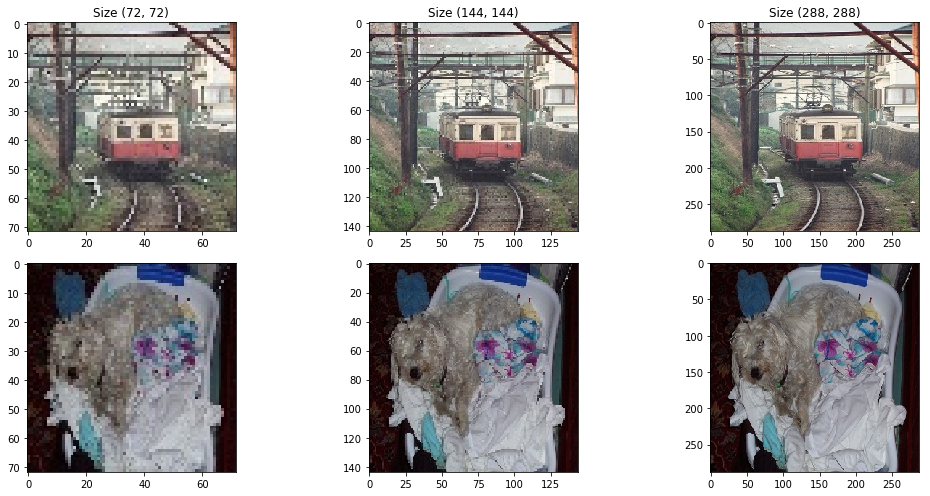

In [23]:
def plot_image(ax, row_idx, img_name):
  for col_idx, img_size in enumerate(image_sizes):
    img = cv2.imread(DATASET_DIR + img_name + '_' + str(img_size) + '.jpg')
    ax[row_idx, col_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
for row_idx, img_idx in enumerate([1, 8]):
  plot_image(ax, row_idx, img_list[img_idx])
for col, img_size in zip(ax[0], image_sizes):
  col.set_title('Size ({:d}, {:d})'.format(img_size, img_size))
fig.tight_layout()
plt.show()

In [24]:
class DatasetFromList1(Dataset):
  def __init__(self, img_list, img_size):
    super(DatasetFromList1, self).__init__()
    self.source = [DATASET_DIR + img_name + '_' + str(SMALL_IMG_SIZE) + '.jpg' for img_name in img_list]
    self.target = [DATASET_DIR + img_name + '_' + str(img_size) + '.jpg' for img_name in img_list]
 
  def get_img(self, index):
    source = cv2.imread(self.source[index])
    target = cv2.imread(self.target[index])
    return source, target

  def __getitem__(self, index):
    source, target = self.get_img(index)
    return img_to_tensor(source), img_to_tensor(target)

  def __len__(self):
    return len(self.source)

train_set, test_set = train_test_split(img_list, test_size=0.2)

train_med = DatasetFromList1(train_set, MEDIUM_IMG_SIZE)
train_large = DatasetFromList1(train_set, LARGE_IMG_SIZE)

test_med = DatasetFromList1(test_set, MEDIUM_IMG_SIZE)
test_large = DatasetFromList1(test_set, LARGE_IMG_SIZE)

## Stage 2

In [167]:
batch_size = 32
input_size = SMALL_IMG_SIZE
lr = 10e-4
n_epochs = 6
n_threads = 1
stats_step = int(len(img_list) / 100)

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### First Model

In [29]:
reshape = lambda x, output_h_w: x.view(-1, output_h_w[0], output_h_w[1], 3)

class Net1(nn.Module):
  def __init__(self, out_channels, output_h_w):
    super(Net1, self).__init__()
    self.input_h_w = (input_size, input_size)
    self.output_h_w = output_h_w
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)

    self._initialize_weights()

  def forward(self, x):
    x = x.view(-1, 3, self.input_h_w[0], self.input_h_w[1]).float()
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = nn.functional.interpolate(x, self.output_h_w[1])
    x = self.final_conv(x)
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x

  def _initialize_weights(self):
    init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.final_conv.weight)

In [30]:
def build_first_model(train_dataset, test_dataset, output_h_w, batch_size):    
    out_channels = 64
    torch.cuda.empty_cache()

    print('===> Loading datasets')
    training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print('===> Building model')
    model = Net1(out_channels, output_h_w=output_h_w).to(device)
    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    def train(epoch):
        epoch_loss = 0
        model.train()
        for iteration, batch in enumerate(training_data_loader, 1):
            source, target = batch[0].to(device), batch[1].to(device)
            target = reshape(target, output_h_w).float()

            optimizer.zero_grad()
            pred = model(source).view(target.shape)
            loss = criterion(pred, target)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            if iteration % stats_step == 0:
                print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

        print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

    def test():
        psnr = 0
        model.eval()
        with torch.no_grad():
            for batch in testing_data_loader:
                source, target = batch[0].to(device), batch[1].to(device)
                target = reshape(target, output_h_w).float()
                prediction = model(source).view(target.shape)
                loss = criterion(prediction, target).item()
                psnr += 10 * np.log10(1 / loss)
        print("===> Avg. PSNR: {:.4f} dB".format(psnr / len(testing_data_loader)))


    def checkpoint(epoch):
        model_out_path = "model_1_epoch_{}_{}.pth".format(output_h_w[0], epoch)
        torch.save(model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))


    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
        checkpoint(epoch)
    
    return model

model1_med = build_first_model(train_med, test_med, output_h_w=(MEDIUM_IMG_SIZE, MEDIUM_IMG_SIZE), batch_size=24)
model1_large = build_first_model(train_large, test_large, output_h_w=(LARGE_IMG_SIZE, LARGE_IMG_SIZE), batch_size=12)

===> Loading datasets
===> Building model
===> Epoch[1](50/167): Loss: 0.0079
===> Epoch[1](100/167): Loss: 0.0087
===> Epoch[1](150/167): Loss: 0.0084
===> Epoch 1 Complete: Avg. Loss: 0.0111
===> Avg. PSNR: 21.4744 dB
Checkpoint saved to model_1_epoch_144_1.pth
===> Epoch[2](50/167): Loss: 0.0064
===> Epoch[2](100/167): Loss: 0.0068
===> Epoch[2](150/167): Loss: 0.0078
===> Epoch 2 Complete: Avg. Loss: 0.0073
===> Avg. PSNR: 21.6684 dB
Checkpoint saved to model_1_epoch_144_2.pth
===> Epoch[3](50/167): Loss: 0.0067
===> Epoch[3](100/167): Loss: 0.0080
===> Epoch[3](150/167): Loss: 0.0083
===> Epoch 3 Complete: Avg. Loss: 0.0070
===> Avg. PSNR: 21.8146 dB
Checkpoint saved to model_1_epoch_144_3.pth
===> Epoch[4](50/167): Loss: 0.0066
===> Epoch[4](100/167): Loss: 0.0055
===> Epoch[4](150/167): Loss: 0.0069
===> Epoch 4 Complete: Avg. Loss: 0.0069
===> Avg. PSNR: 21.8458 dB
Checkpoint saved to model_1_epoch_144_4.pth
===> Epoch[5](50/167): Loss: 0.0094
===> Epoch[5](100/167): Loss: 0.00

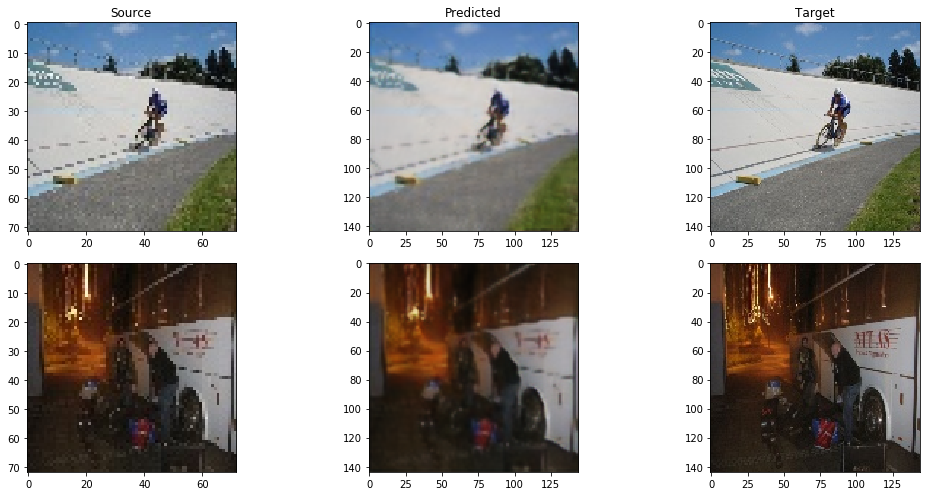

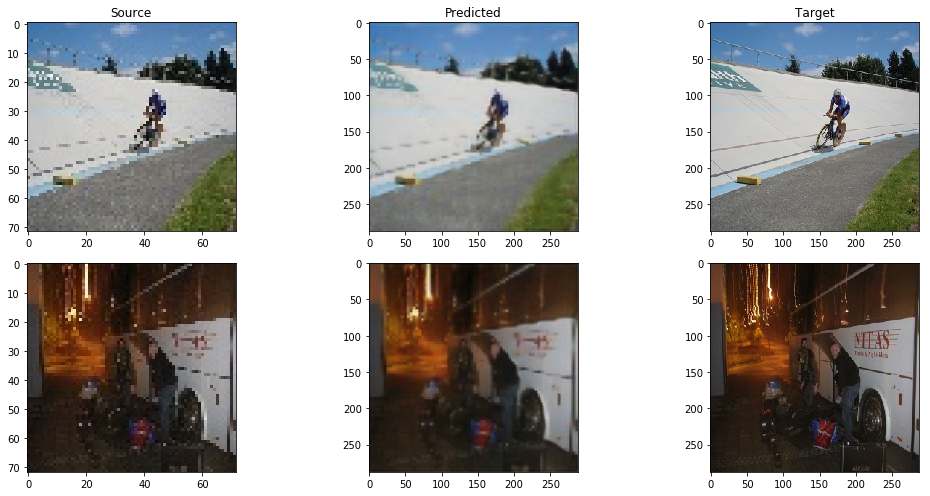

In [31]:
def plot_first_model(model, dataset):
    fig, ax = plt.subplots(2, 3, figsize=(15, 7))
    for row_idx, img_idx in enumerate([1, 5]):
        source, target = dataset[img_idx]
        predicted = model(source.to(device)).cpu().squeeze(0).float().detach()
        ax[row_idx, 0].imshow(tensor_to_img(source))
        ax[row_idx, 1].imshow(tensor_to_img(predicted))
        ax[row_idx, 2].imshow(tensor_to_img(target))
    for col, title in zip(ax[0], ['Source', 'Predicted', 'Target']):
        col.set_title(title)
    fig.tight_layout()
    plt.show()

plot_first_model(model1_med, test_med)
plot_first_model(model1_large, test_large)

## Stage 3

In [32]:
output_sizes = (MEDIUM_IMG_SIZE, LARGE_IMG_SIZE)

### Second Model

In [86]:
class DatasetFromList(Dataset):
  def __init__(self, img_list, img_sizes):
    super(DatasetFromList, self).__init__()
    self.source = [DATASET_DIR + img_name + '_' + str(SMALL_IMG_SIZE) + '.jpg' for img_name in img_list]
    self.targets = [
        [DATASET_DIR + img_name + '_' + str(img_size) + '.jpg' for img_name in img_list]
        for img_size in img_sizes]


  def __getitem__(self, img_idx):
    source = cv2.imread(self.source[img_idx])
    targets = [img_to_tensor(cv2.imread(target[img_idx])) for target in self.targets]
    return img_to_tensor(source), targets

  def __len__(self):
    return len(self.source)

output_image_sizes = (MEDIUM_IMG_SIZE, LARGE_IMG_SIZE)

train_dataset = DatasetFromList(train_set, output_image_sizes)
test_dataset = DatasetFromList(test_set, output_image_sizes)

In [87]:
class Net2(nn.Module):
  def __init__(self, input_size, out_channels, output_sizes):
    super(Net2, self).__init__()
    self.input_size = input_size
    self.output_sizes = output_sizes
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.final_conv1 = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)
    self.final_conv2 = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)

    self._initialize_weights()

  def forward(self, x):
    x = x.view(-1, 3, self.input_size, self.input_size).float()
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    y0 = nn.functional.interpolate(x, self.output_sizes[0])
    y1 = nn.functional.interpolate(y0, self.output_sizes[1])
    return [self._apply_final_conv(y0, self.final_conv1), self._apply_final_conv(y1, self.final_conv2)] 

  def _apply_final_conv(self, x, conv):
    x = conv(x)
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x
    
  def _initialize_weights(self):
    init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.final_conv1.weight)
    init.orthogonal_(self.final_conv2.weight)

In [260]:
def load_from_checkpoint(model, optimizer, filename = 'checkpoint.pth.tar'):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
        return model, optimizer
    
def build_model(batch_size, lr, n_epochs, out_channels, NetContsrtuctor, model_name, weight_loss = True, opt_func=None, criterion=nn.MSELoss, resume=None):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print('===> Loading datasets')
    training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print('===> Building model')
    model = NetContsrtuctor(input_size, out_channels, output_sizes).to(device)

    if opt_func:
        optimizer = opt_func(model)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    if resume:
        model, optimizer = load_from_checkpoint(model, optimizer, filename=resume)
        
    criterions = [criterion() for i in range(len(output_sizes))]

    def compute_loss(pred, targets, override_criterion=None):
        loss = None
        cs = list(override_criterion() for i in range(len(targets))) if override_criterion else criterions
        for i, target in enumerate(targets):
            view_shape = (-1, output_sizes[i], output_sizes[i], 3)
            weight = output_sizes[i] ** 2 / np.square(output_sizes).sum()
            curr_loss = cs[i](pred[i].view(view_shape), target.view(view_shape)) * weight
            loss = curr_loss if loss is None else loss + curr_loss
        return loss 

    def train(epoch):
        epoch_loss = 0
        model.train()
        for iteration, batch in enumerate(training_data_loader, 1):
            source, targets = batch[0].to(device), (batch[1][0].to(device), batch[1][1].to(device))

            optimizer.zero_grad()
            loss = compute_loss(model(source), targets)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            if iteration % stats_step == 0:
                print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

        print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

    def test():
        psnr = 0
        mse = nn.MSELoss
        model.eval()
        with torch.no_grad():
            for batch in testing_data_loader:
                source, targets = batch[0].to(device), (batch[1][0].to(device), batch[1][1].to(device))            
                loss = compute_loss(model(source), targets, override_criterion=mse).item()
                psnr += 10 * np.log10(1 / loss)
        print("===> Avg. PSNR: {:.4f} dB".format(psnr / len(testing_data_loader)))


    def checkpoint(epoch):
        model_out_path = "model_{}_epoch_{}.pth".format(model_name, epoch)
        cpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }
        torch.save(cpoint, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))
        
    
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
        checkpoint(epoch)
        if epoch % 10 == 0:
            plot_results(model, img_indices=[55, 82])
    
    return model

In [196]:
model2 = build_model(batch_size=batch_size, lr=lr, n_epochs=1, out_channels=32, NetContsrtuctor=Net2, model_name='net2')

===> Loading datasets
===> Building model
===> Epoch[1](50/126): Loss: 0.0104
===> Epoch[1](100/126): Loss: 0.0086
===> Epoch 1 Complete: Avg. Loss: 0.0204
===> Avg. PSNR: 21.0252 dB
Checkpoint saved to model_net2_epoch_1.pth


In [136]:
def plot_results(model, img_indices):
    fig, ax = plt.subplots(2, 5, figsize=(15, 7))
    for row_idx, img_idx in enumerate(img_indices):
        source, targets = test_dataset[img_idx]
        predicted = model(source.to(device))
        ax[row_idx, 0].imshow(tensor_to_img(source))
        ax[row_idx, 1].imshow(tensor_to_img(predicted[0].cpu().squeeze(0).float().detach()))
        ax[row_idx, 2].imshow(tensor_to_img(predicted[1].cpu().squeeze(0).float().detach()))
        ax[row_idx, 3].imshow(tensor_to_img(targets[0]))
        ax[row_idx, 4].imshow(tensor_to_img(targets[1]))
    for col, title in zip(ax[0], ['Source', 'Predicted Medium', 'Predicted Large', 'Target Medium', 'Target Large']):
        col.set_title(title)
    fig.tight_layout()
    plt.show()

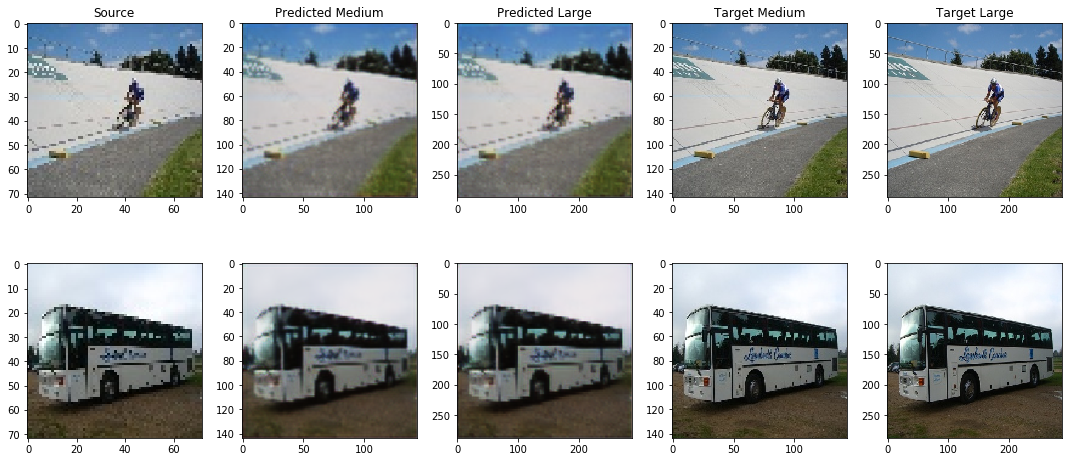

In [137]:
plot_results(model2, img_indices=[1, 8])

## Stage 4

### Third Model

In [39]:
class Net3(nn.Module):
  def __init__(self, input_size, out_channels, output_sizes):
    super(Net3, self).__init__()
    self.input_size = input_size
    self.output_sizes = output_sizes
    # This layer doesn't appear in the diagram
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.res1 = self._create_res_block(out_channels)
    self.res2 = self._create_res_block(out_channels)
    self.res3 = self._create_res_block(out_channels)
    self.final_conv1 = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)
    self.final_conv2 = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)

  def forward(self, x):
    x = x.view(-1, 3, self.input_size, self.input_size).float()
    x = self.conv1(x)
    x = F.relu(torch.add(x, self.res1(x)))
    x = F.relu(torch.add(x, self.res2(x)))
    y0 = nn.functional.interpolate(x, self.output_sizes[0])
    y1 = F.relu(torch.add(y0, self.res3(y0)))
    y1 = nn.functional.interpolate(y1, self.output_sizes[1])
    return [self._apply_final_conv(y0, self.final_conv1), self._apply_final_conv(y1, self.final_conv2)] 
  
  def _create_res_block(self, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    )

  def _apply_final_conv(self, x, conv):
    x = conv(x)
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x

In [40]:
model3 = build_model(batch_size=batch_size, lr=lr, n_epochs=n_epochs, out_channels=32, NetContsrtuctor=Net3, model_name='net3')

===> Loading datasets
===> Building model
===> Epoch[1](50/668): Loss: 0.0183
===> Epoch[1](100/668): Loss: 0.0143
===> Epoch[1](150/668): Loss: 0.0136
===> Epoch[1](200/668): Loss: 0.0091
===> Epoch[1](250/668): Loss: 0.0213
===> Epoch[1](300/668): Loss: 0.0119
===> Epoch[1](350/668): Loss: 0.0129
===> Epoch[1](400/668): Loss: 0.0165
===> Epoch[1](450/668): Loss: 0.0098
===> Epoch[1](500/668): Loss: 0.0144
===> Epoch[1](550/668): Loss: 0.0240
===> Epoch[1](600/668): Loss: 0.0126
===> Epoch[1](650/668): Loss: 0.0177
===> Epoch 1 Complete: Avg. Loss: 0.0175
===> Avg. PSNR: 18.9520 dB
Checkpoint saved to model_net3_epoch_1.pth
===> Epoch[2](50/668): Loss: 0.0112
===> Epoch[2](100/668): Loss: 0.0150
===> Epoch[2](150/668): Loss: 0.0148
===> Epoch[2](200/668): Loss: 0.0134
===> Epoch[2](250/668): Loss: 0.0172
===> Epoch[2](300/668): Loss: 0.0144
===> Epoch[2](350/668): Loss: 0.0092
===> Epoch[2](400/668): Loss: 0.0160
===> Epoch[2](450/668): Loss: 0.0136
===> Epoch[2](500/668): Loss: 0.013

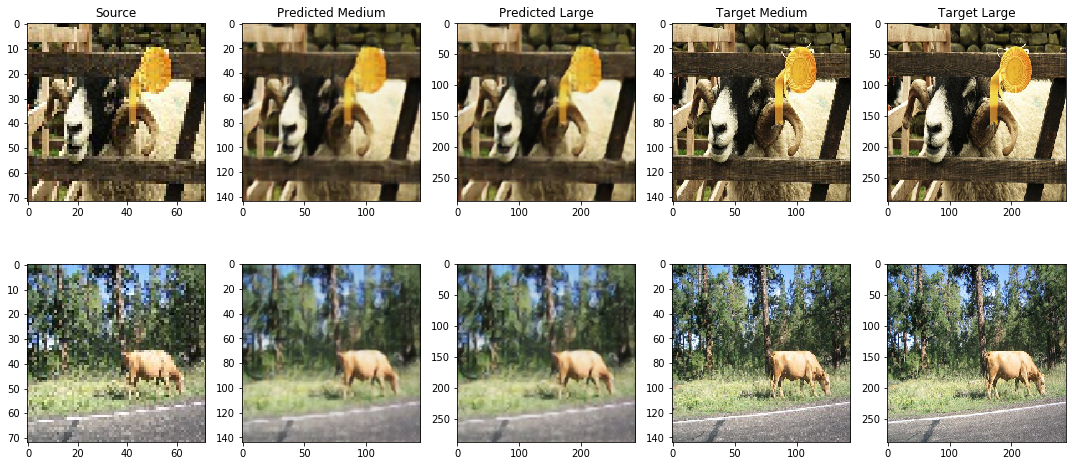

In [19]:
plot_results(model3, img_indices=[1, 8])

## Stage 5

### Fourth Model

In [20]:
class Net4(nn.Module):
  def __init__(self, input_size, out_channels, output_sizes):
    super(Net4, self).__init__()
    self.input_size = input_size
    self.output_sizes = output_sizes
    # This layer doesn't appear in the diagram
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.dil1 = self._create_dil_block(out_channels)
    self.conv2 = nn.Conv2d(in_channels=3*out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.dil2 = self._create_dil_block(out_channels)
    self.conv3 = nn.Conv2d(in_channels=3*out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.dil3 = self._create_dil_block(out_channels)
    self.conv4 = nn.Conv2d(in_channels=3*out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.final_conv1 = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)
    self.final_conv2 = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)

  def forward(self, x):
    x = x.view(-1, 3, self.input_size, self.input_size).float()
    x = self.conv1(x)
    x = self._apply_dil_block(x, self.dil1, self.conv2)
    x = self._apply_dil_block(x, self.dil2, self.conv3)
    y0 = nn.functional.interpolate(x, self.output_sizes[0])
    y1 = self._apply_dil_block(y0, self.dil3, self.conv4)
    y1 = nn.functional.interpolate(y1, self.output_sizes[1])
    return [self._apply_final_conv(y0, self.final_conv1), self._apply_final_conv(y1, self.final_conv2)] 
  
  def _create_dil_block(self, out_channels):
    return (
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding=1, kernel_size=3, dilation=1),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding=2, kernel_size=3, dilation=2),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding=4, kernel_size=3, dilation=4)
    )
  
  def _apply_dil_block(self, x, dil_block, conv):
    cat = torch.cat([dil(x) for dil in dil_block], 1)
    x = F.relu(cat)
    return conv(x)

  def _apply_final_conv(self, x, conv):
    x = conv(x)
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x

In [21]:
model4 = build_model(batch_size=batch_size, lr=lr, n_epochs=n_epochs, out_channels=32, NetContsrtuctor=Net4, model_name='net4')

===> Loading datasets
===> Building model
===> Epoch[1](50/668): Loss: 0.0362
===> Epoch[1](100/668): Loss: 0.0286
===> Epoch[1](150/668): Loss: 0.0259
===> Epoch[1](200/668): Loss: 0.0237
===> Epoch[1](250/668): Loss: 0.0244
===> Epoch[1](300/668): Loss: 0.0155
===> Epoch[1](350/668): Loss: 0.0150
===> Epoch[1](400/668): Loss: 0.0121
===> Epoch[1](450/668): Loss: 0.0176
===> Epoch[1](500/668): Loss: 0.0173
===> Epoch[1](550/668): Loss: 0.0150
===> Epoch[1](600/668): Loss: 0.0102
===> Epoch[1](650/668): Loss: 0.0072
===> Epoch 1 Complete: Avg. Loss: 0.0207
===> Avg. PSNR: 18.4941 dB
Checkpoint saved to model2_epoch_1.pth
===> Epoch[2](50/668): Loss: 0.0115
===> Epoch[2](100/668): Loss: 0.0117
===> Epoch[2](150/668): Loss: 0.0133
===> Epoch[2](200/668): Loss: 0.0189
===> Epoch[2](250/668): Loss: 0.0147
===> Epoch[2](300/668): Loss: 0.0141
===> Epoch[2](350/668): Loss: 0.0154
===> Epoch[2](400/668): Loss: 0.0080
===> Epoch[2](450/668): Loss: 0.0171
===> Epoch[2](500/668): Loss: 0.0103
==

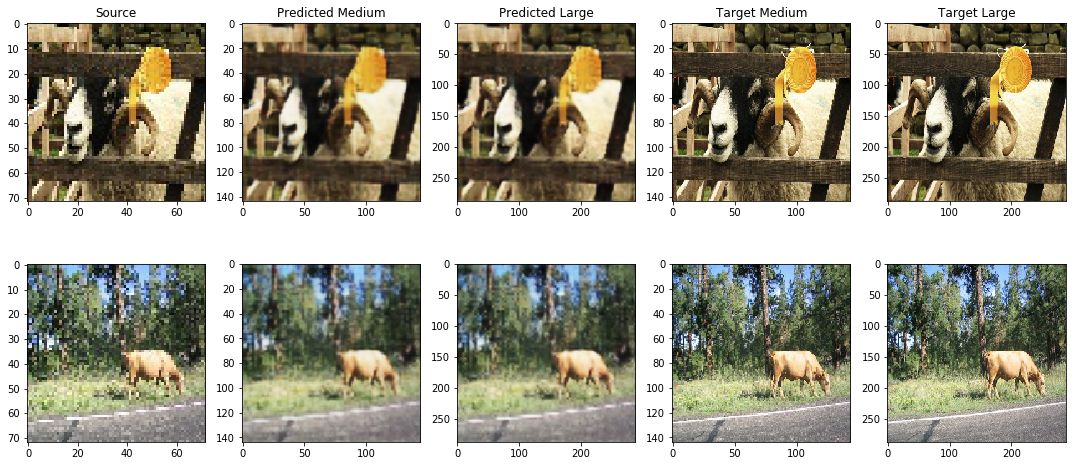

In [59]:
plot_results(model4, img_indices=[1, 8])

## Stage 6

### Fifth Model

In [41]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth


In [54]:
for param in model.parameters():
    param.requires_grad = False
# block1conv2 = model.features[2]
block1conv2 = model.features[:3]
block1conv2

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [58]:
class Net5(nn.Module):
  def __init__(self, input_size, out_channels, output_sizes):
    super(Net5, self).__init__()
    self.input_size = input_size
    self.output_sizes = output_sizes
    # This layer doesn't appear in the diagram
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.vgg_conv = block1conv2
    self.conv4 = nn.Conv2d(in_channels=2*out_channels, out_channels=3, padding = 0, kernel_size=1)
    self.conv5 = nn.Conv2d(in_channels=3, out_channels=3, padding = 0, kernel_size=1)

  def forward(self, x0):
    x0 = x0.view(-1, 3, self.input_size, self.input_size).float()
    x_vgg = self.vgg_conv(x0)
    x0 = F.relu(self.conv1(x0))
    x1 = self.conv2(x0)
    x = torch.cat([x1, x_vgg], 1)
    y0 = self.conv4(nn.functional.interpolate(x, self.output_sizes[0]))
    y1 = self.conv5(nn.functional.interpolate(y0, self.output_sizes[1]))
    return [self._apply_final(y0), self._apply_final(y1)] 

  def _apply_final(self, x):
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x

In [59]:
model5 = build_model(batch_size=batch_size, lr=lr, n_epochs=n_epochs, out_channels=64, NetContsrtuctor=Net5, model_name='net5')

===> Loading datasets
===> Building model
===> Epoch[1](50/668): Loss: 0.0741
===> Epoch[1](100/668): Loss: 0.0538
===> Epoch[1](150/668): Loss: 0.0424
===> Epoch[1](200/668): Loss: 0.0432
===> Epoch[1](250/668): Loss: 0.0412
===> Epoch[1](300/668): Loss: 0.0326
===> Epoch[1](350/668): Loss: 0.0368
===> Epoch[1](400/668): Loss: 0.0270
===> Epoch[1](450/668): Loss: 0.0274
===> Epoch[1](500/668): Loss: 0.0325
===> Epoch[1](550/668): Loss: 0.0268
===> Epoch[1](600/668): Loss: 0.0207
===> Epoch[1](650/668): Loss: 0.0158
===> Epoch 1 Complete: Avg. Loss: 0.0394
===> Avg. PSNR: 16.9238 dB
Checkpoint saved to model_net5_epoch_1.pth
===> Epoch[2](50/668): Loss: 0.0129
===> Epoch[2](100/668): Loss: 0.0199
===> Epoch[2](150/668): Loss: 0.0161
===> Epoch[2](200/668): Loss: 0.0218
===> Epoch[2](250/668): Loss: 0.0086
===> Epoch[2](300/668): Loss: 0.0195
===> Epoch[2](350/668): Loss: 0.0175
===> Epoch[2](400/668): Loss: 0.0180
===> Epoch[2](450/668): Loss: 0.0149
===> Epoch[2](500/668): Loss: 0.009

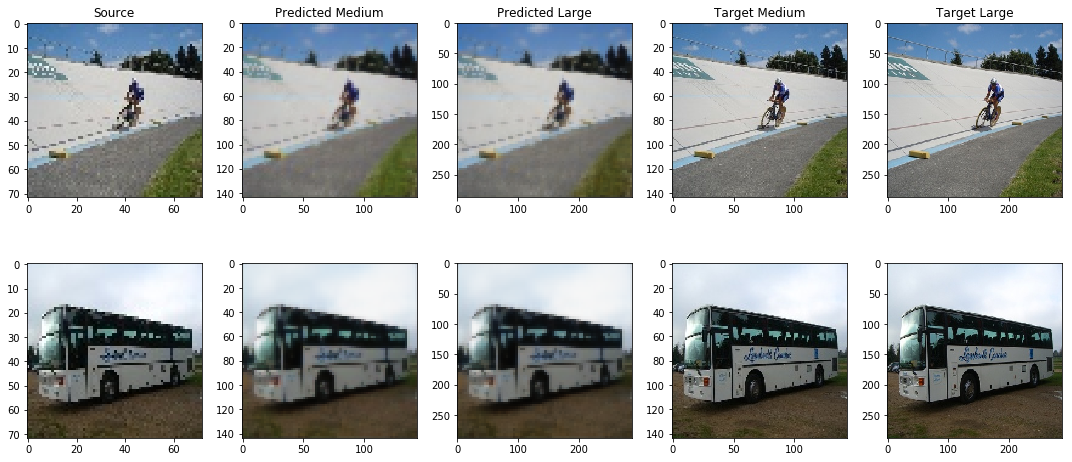

In [60]:
plot_results(model5, img_indices=[1, 8])

In [256]:
#Model which uses VGG features + transposed convolutions + SSIM loss
class Net6(nn.Module):
    
    
  def __init__(self, input_size, out_channels, output_sizes):
    super(Net6, self).__init__()
    self.input_size = input_size
    self.output_sizes = output_sizes
    # This layer doesn't appear in the diagram
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.vgg_conv = block1conv2
    self.conv4 = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 0, kernel_size=1)
    self.conv5 = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 0, kernel_size=1)
    self.conv_transpose1 = nn.ConvTranspose2d(in_channels=(64 + out_channels), out_channels=out_channels, stride=2, padding = 1, kernel_size=4)
    self.conv_transpose2 = nn.ConvTranspose2d(in_channels=out_channels , out_channels=out_channels, stride=2, padding = 1, kernel_size=4)
    self.act = nn.functional.leaky_relu
    init.xavier_normal(self.conv1.weight, init.calculate_gain('leaky_relu'))
    init.xavier_normal(self.conv2.weight, init.calculate_gain('leaky_relu'))
    init.xavier_normal(self.conv4.weight, init.calculate_gain('leaky_relu'))
    init.xavier_normal(self.conv5.weight, init.calculate_gain('leaky_relu'))
    init.xavier_normal(self.conv_transpose1.weight, init.calculate_gain('leaky_relu'))
    init.xavier_normal(self.conv_transpose2.weight, init.calculate_gain('leaky_relu'))


  def forward(self, x0):
    act = self.act
    x0 = x0.view(-1, 3, self.input_size, self.input_size).float()
    x_vgg = self.vgg_conv(x0)
    x1 = act(self.conv1(x0))
    x1 = act(self.conv2(x1))
    x = torch.cat([x1, x_vgg], 1)
    x = act(self.conv_transpose1(x))
    y0 = self.conv4(x)
    x = act(self.conv_transpose2(x))
    y1 = self.conv5(x)
    return [self._apply_final(y0), self._apply_final(y1)] 

  def _apply_final(self, x):
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x

===> Loading datasets
===> Building model
===> Epoch[1](50/126): Loss: 0.2111
===> Epoch[1](100/126): Loss: 0.1823
===> Epoch 1 Complete: Avg. Loss: 0.2497
===> Avg. PSNR: 20.2535 dB
Checkpoint saved to model_net6_epoch_1.pth
===> Epoch[2](50/126): Loss: 0.1737
===> Epoch[2](100/126): Loss: 0.1672
===> Epoch 2 Complete: Avg. Loss: 0.1678
===> Avg. PSNR: 21.3094 dB
Checkpoint saved to model_net6_epoch_2.pth
===> Epoch[3](50/126): Loss: 0.1597
===> Epoch[3](100/126): Loss: 0.1629
===> Epoch 3 Complete: Avg. Loss: 0.1603
===> Avg. PSNR: 21.4681 dB
Checkpoint saved to model_net6_epoch_3.pth
===> Epoch[4](50/126): Loss: 0.1444
===> Epoch[4](100/126): Loss: 0.1449
===> Epoch 4 Complete: Avg. Loss: 0.1572
===> Avg. PSNR: 21.7683 dB
Checkpoint saved to model_net6_epoch_4.pth
===> Epoch[5](50/126): Loss: 0.1646
===> Epoch[5](100/126): Loss: 0.1552
===> Epoch 5 Complete: Avg. Loss: 0.1555
===> Avg. PSNR: 21.8305 dB
Checkpoint saved to model_net6_epoch_5.pth
===> Epoch[6](50/126): Loss: 0.1363
==

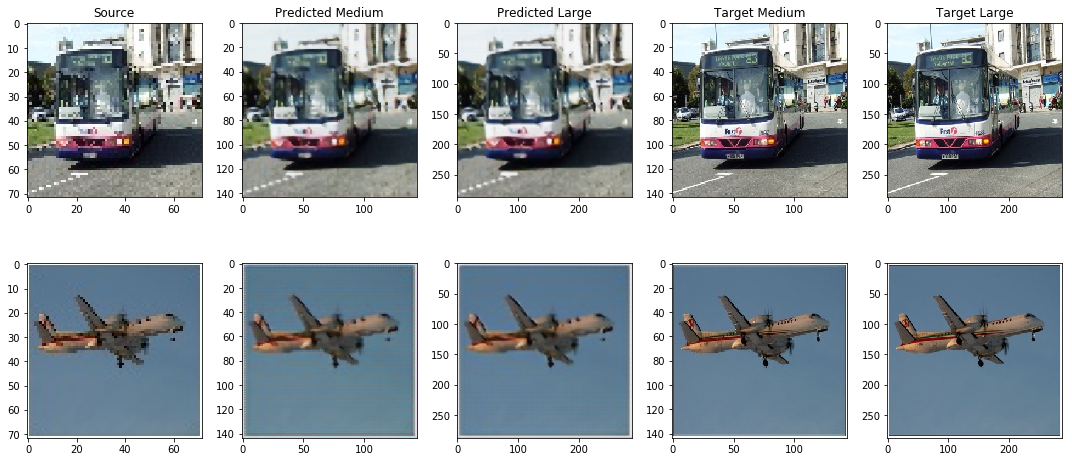

===> Epoch[11](50/126): Loss: 0.1436
===> Epoch[11](100/126): Loss: 0.1632
===> Epoch 11 Complete: Avg. Loss: 0.1521
===> Avg. PSNR: 21.9760 dB
Checkpoint saved to model_net6_epoch_11.pth
===> Epoch[12](50/126): Loss: 0.1473
===> Epoch[12](100/126): Loss: 0.1484
===> Epoch 12 Complete: Avg. Loss: 0.1519
===> Avg. PSNR: 21.9785 dB
Checkpoint saved to model_net6_epoch_12.pth
===> Epoch[13](50/126): Loss: 0.1499
===> Epoch[13](100/126): Loss: 0.1547
===> Epoch 13 Complete: Avg. Loss: 0.1512
===> Avg. PSNR: 22.0876 dB
Checkpoint saved to model_net6_epoch_13.pth
===> Epoch[14](50/126): Loss: 0.1444
===> Epoch[14](100/126): Loss: 0.1374
===> Epoch 14 Complete: Avg. Loss: 0.1511
===> Avg. PSNR: 22.0207 dB
Checkpoint saved to model_net6_epoch_14.pth
===> Epoch[15](50/126): Loss: 0.1371
===> Epoch[15](100/126): Loss: 0.1481
===> Epoch 15 Complete: Avg. Loss: 0.1509
===> Avg. PSNR: 22.0785 dB
Checkpoint saved to model_net6_epoch_15.pth
===> Epoch[16](50/126): Loss: 0.1473
===> Epoch[16](100/126)

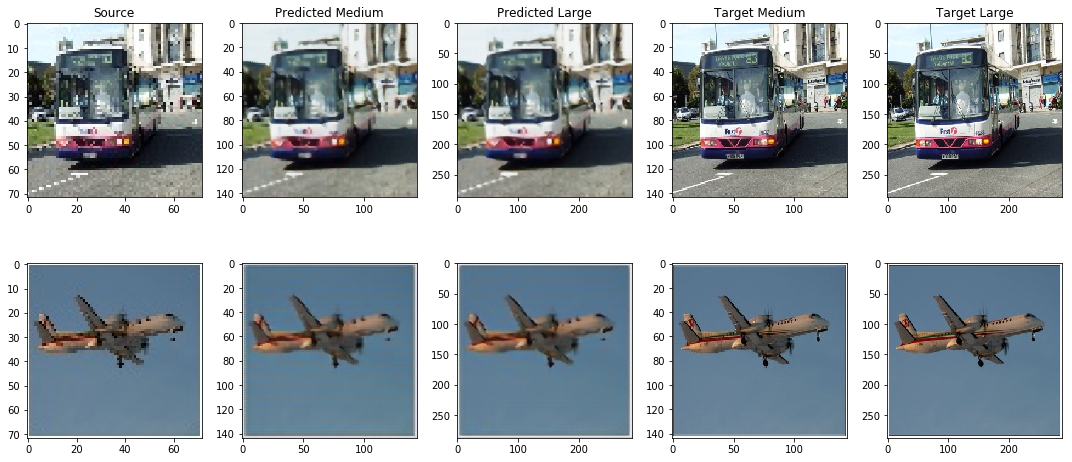

===> Epoch[21](50/126): Loss: 0.1387
===> Epoch[21](100/126): Loss: 0.1474
===> Epoch 21 Complete: Avg. Loss: 0.1500
===> Avg. PSNR: 22.1261 dB
Checkpoint saved to model_net6_epoch_21.pth
===> Epoch[22](50/126): Loss: 0.1400
===> Epoch[22](100/126): Loss: 0.1497
===> Epoch 22 Complete: Avg. Loss: 0.1496
===> Avg. PSNR: 22.1388 dB
Checkpoint saved to model_net6_epoch_22.pth
===> Epoch[23](50/126): Loss: 0.1310
===> Epoch[23](100/126): Loss: 0.1388
===> Epoch 23 Complete: Avg. Loss: 0.1497
===> Avg. PSNR: 22.1255 dB
Checkpoint saved to model_net6_epoch_23.pth
===> Epoch[24](50/126): Loss: 0.1407
===> Epoch[24](100/126): Loss: 0.1554
===> Epoch 24 Complete: Avg. Loss: 0.1496
===> Avg. PSNR: 22.1343 dB
Checkpoint saved to model_net6_epoch_24.pth
===> Epoch[25](50/126): Loss: 0.1476
===> Epoch[25](100/126): Loss: 0.1393
===> Epoch 25 Complete: Avg. Loss: 0.1492
===> Avg. PSNR: 22.1181 dB
Checkpoint saved to model_net6_epoch_25.pth
===> Epoch[26](50/126): Loss: 0.1488
===> Epoch[26](100/126)

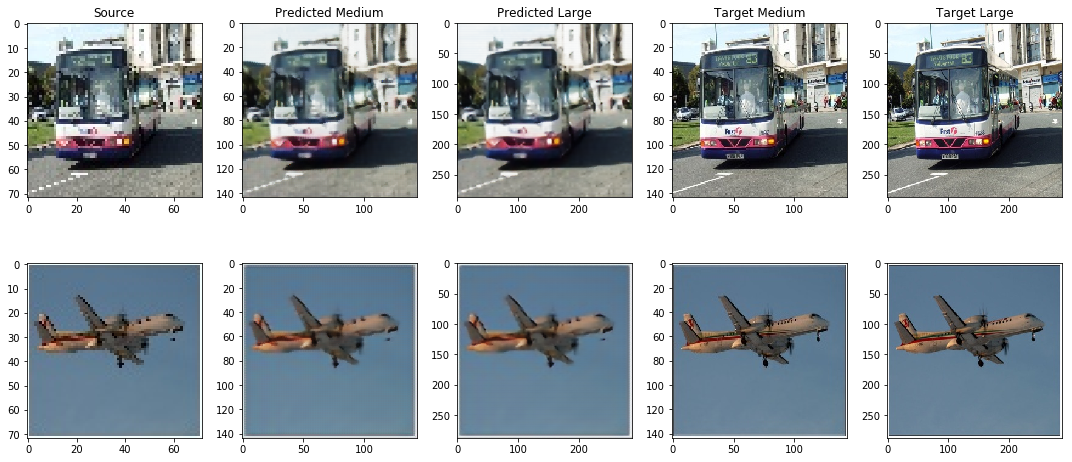

===> Epoch[31](50/126): Loss: 0.1232
===> Epoch[31](100/126): Loss: 0.1403
===> Epoch 31 Complete: Avg. Loss: 0.1487
===> Avg. PSNR: 22.1688 dB
Checkpoint saved to model_net6_epoch_31.pth
===> Epoch[32](50/126): Loss: 0.1635
===> Epoch[32](100/126): Loss: 0.1664
===> Epoch 32 Complete: Avg. Loss: 0.1488
===> Avg. PSNR: 22.1422 dB
Checkpoint saved to model_net6_epoch_32.pth
===> Epoch[33](50/126): Loss: 0.1505
===> Epoch[33](100/126): Loss: 0.1600
===> Epoch 33 Complete: Avg. Loss: 0.1487
===> Avg. PSNR: 22.1036 dB
Checkpoint saved to model_net6_epoch_33.pth
===> Epoch[34](50/126): Loss: 0.1338
===> Epoch[34](100/126): Loss: 0.1391
===> Epoch 34 Complete: Avg. Loss: 0.1486
===> Avg. PSNR: 22.1681 dB
Checkpoint saved to model_net6_epoch_34.pth
===> Epoch[35](50/126): Loss: 0.1542
===> Epoch[35](100/126): Loss: 0.1576
===> Epoch 35 Complete: Avg. Loss: 0.1489
===> Avg. PSNR: 22.0131 dB
Checkpoint saved to model_net6_epoch_35.pth
===> Epoch[36](50/126): Loss: 0.1342
===> Epoch[36](100/126)

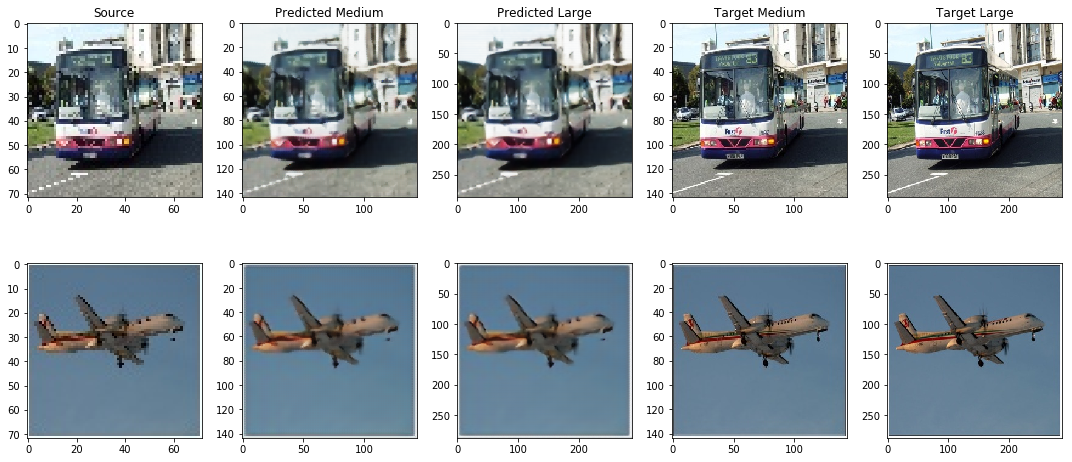

===> Epoch[41](50/126): Loss: 0.1495
===> Epoch[41](100/126): Loss: 0.1319
===> Epoch 41 Complete: Avg. Loss: 0.1482
===> Avg. PSNR: 22.1428 dB
Checkpoint saved to model_net6_epoch_41.pth
===> Epoch[42](50/126): Loss: 0.1583
===> Epoch[42](100/126): Loss: 0.1385
===> Epoch 42 Complete: Avg. Loss: 0.1481
===> Avg. PSNR: 22.1540 dB
Checkpoint saved to model_net6_epoch_42.pth
===> Epoch[43](50/126): Loss: 0.1655
===> Epoch[43](100/126): Loss: 0.1462
===> Epoch 43 Complete: Avg. Loss: 0.1479
===> Avg. PSNR: 22.1778 dB
Checkpoint saved to model_net6_epoch_43.pth
===> Epoch[44](50/126): Loss: 0.1438
===> Epoch[44](100/126): Loss: 0.1462
===> Epoch 44 Complete: Avg. Loss: 0.1478
===> Avg. PSNR: 22.1344 dB
Checkpoint saved to model_net6_epoch_44.pth
===> Epoch[45](50/126): Loss: 0.1456
===> Epoch[45](100/126): Loss: 0.1277
===> Epoch 45 Complete: Avg. Loss: 0.1480
===> Avg. PSNR: 22.1041 dB
Checkpoint saved to model_net6_epoch_45.pth
===> Epoch[46](50/126): Loss: 0.1478
===> Epoch[46](100/126)

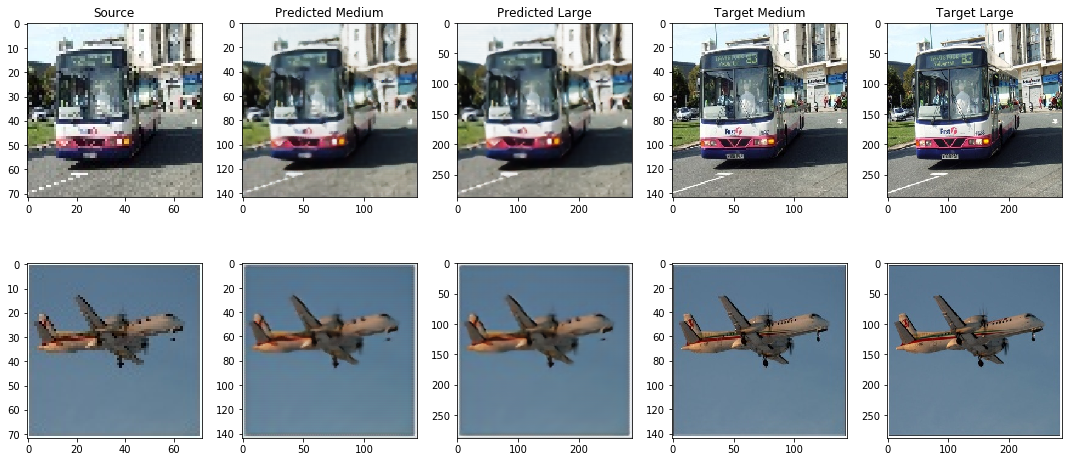

In [261]:
opt_func = lambda model: optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

model6 = build_model(batch_size=batch_size, lr=lr, n_epochs=50, out_channels=40, NetContsrtuctor=Net6, model_name='net6', criterion=ssim_loss, opt_func=opt_func)

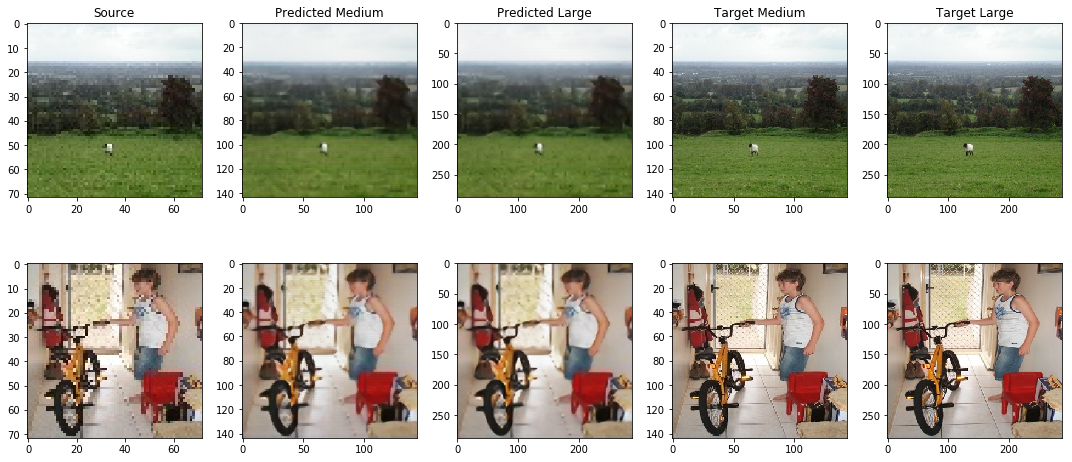

In [273]:
plot_results(model6, img_indices=[197, 198])


In [259]:
### https://github.com/Po-Hsun-Su/pytorch-ssim

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


# ssim_loss = lambda: 
def ssim_loss():
    ssim_3 = SSIM(window_size = 3)
    return lambda y_pred, y: 1 - ssim_3(y_pred, y)